# FMCW Doppler Processing

Includes examples showing:
- How a single target's range and velocity can be obtained using triangular modulation
- Introduction to phase components of reflected LFM signal
- Simulation of range-Doppler spectrum for user-specified (range, velocity) target pairs
- 3D plotting of range-Doppler spectrum

Check out the bottom for a challenge problem!

</br>

> Provided as supplemental material for [Marshall Bruner](https://www.youtube.com/@MarshallBrunerRF)'s [video on the range-Doppler spectrum](https://tinyurl.com/doppler-video-nb).

- [GitHub](https://tinyurl.com/github-nb)
- [YouTube](https://tinyurl.com/marshall-bruner-yt-nb)

In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import c, pi, mph
from numpy.fft import fft, fftshift, fft2
from matplotlib import cm

%matplotlib inline
plt.style.use("ggplot")
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "typeface",
#     }
# )  # Makes plotting slightly slower but prettier (requires LaTeX installed)

## Doppler Estimation Using Triangular Modulation

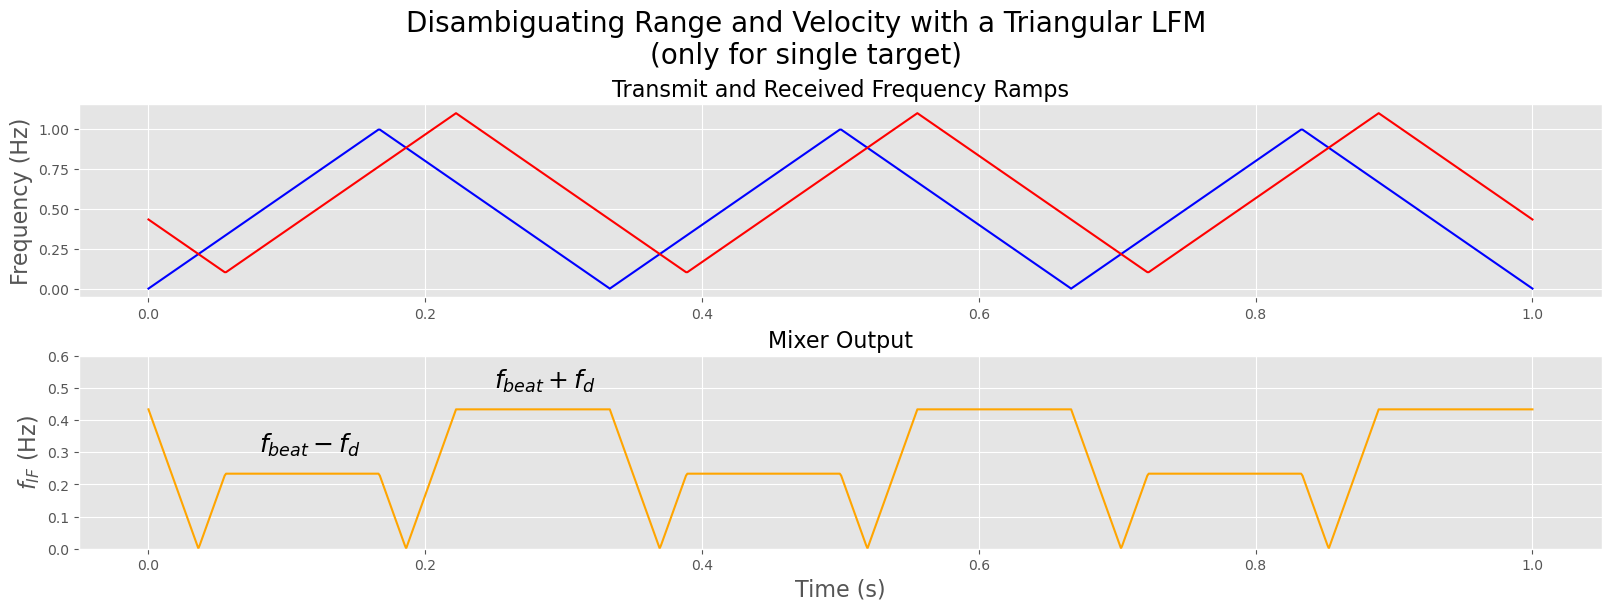

In [2]:
t = np.linspace(0, 1, 1000)
f = 3
range_shift = -pi / 3
doppler_shift = 0.1
tx = (signal.sawtooth(2 * pi * f * t, width=0.5) + 1) / 2
rx = (signal.sawtooth(2 * pi * f * t + range_shift, width=0.5) + 1) / 2 + doppler_shift
if_sig = np.abs(tx - rx)


fig, ax = plt.subplots(2, 1, figsize=(16, 6), layout="constrained")
fig.suptitle(
    "Disambiguating Range and Velocity with a Triangular LFM\n(only for single target)",
    fontsize=20,
)
ax[0].set_ylabel("Frequency (Hz)", fontsize=16)
ax[0].set_title("Transmit and Received Frequency Ramps", fontsize=16)
ax[0].plot(t, tx, label="Tx", c="b")
ax[0].plot(t, rx, label="Rx", c="r")
ax[1].set_ylim([0, 0.6])
ax[1].set_ylabel(r"$f_{IF}$ (Hz)", fontsize=16)
ax[1].set_xlabel("Time (s)", fontsize=16)
ax[1].set_title("Mixer Output", fontsize=16)
ax[1].text(0.08, 0.3, r"$f_{beat} - f_d$", fontsize=18)
ax[1].text(0.25, 0.5, r"$f_{beat} + f_d$", fontsize=18)
ax[1].plot(t, if_sig, label="Rx", c="orange")
plt.show()

This means that we now have 2 known values, $f_{up} = f_{beat} - f_d$ and $f_{down} = f_{beat} + f_d$. Using these we can obtain the range beat frequency, $f_{beat}$, and Doppler frequency shift, $f_d$, of our target

\begin{equation}
  f_d = \frac{f_{down} - f_{up}}{2} \\
  f_{beat} = \frac{f_{down} + f_{up}}{2}
\end{equation}

Then from these frequencies can derive the range and velocity

\begin{equation}
    R = \frac{c T_{c} f_{beat}}{2 B} \\
    v = \frac{f_d \lambda}{2}
\end{equation}

where $c$ is the speed of light, $T_c$ is the chirp time, $B$ is the bandwidth, and $\lambda = c/f$ is the wavelength.


## Trying with real radar parameters

## Single Target

In [3]:
# Radar setup
f = 76e9  # Hz
Tc = 40e-6  # chirp time - s
bw = 1.6e9  # bandwidth - Hz
chirp_rate = bw / Tc  # Hz/s

wavelength = c / f
M = 40  # number of chirps in coherent processing interval (CPI)

# Target
R = 20  # m
v = 10  # m/s

In [4]:
range_resolution = c / (2 * bw)
print(f"Range resolution: {range_resolution:.2f} m")

Range resolution: 0.09 m


In [5]:
time_from_dist = R / c
time_from_vel = 2 * (v * Tc) / c
time_elapsed = time_from_vel + time_from_dist
print(f"Propagation time: {time_elapsed * 1e9:.2f} ns")

Propagation time: 66.72 ns


## Computing phase components
The full equation for phase is

\begin{equation}
    \phi_1 = -(2 \pi \mu \Delta \tau ) t + \pi \mu \Delta \tau^2 + 2 \pi \mu \tau_0 \Delta \tau - 2 \pi f \Delta \tau + \phi_0
\end{equation}

where $\Delta \tau$ is the time difference between chirps due to the radial velocity (`time_from_vel`), $\mu = B / T_c$ is the chirp rate (`chirp_rate`), and $\tau_0$ is the round-trip time due to distance (`time_from_dist`). 3 / 4 of these components will be very small, however, and can be ignored. Below is an example of an automotive system and the values of these components.



\begin{equation}
    2 \pi \mu \Delta \tau
\end{equation}

In [6]:
print(f"{2 * pi * chirp_rate * time_from_vel * Tc:.3f} radians")

0.027 radians


\begin{equation}
    \pi \mu \Delta \tau^2
\end{equation}

In [7]:
print(f"{pi * chirp_rate * time_from_vel**2 * 1e10:.3f} * 10^-10 radians")

8.948 * 10^-10 radians


\begin{equation}
    2 \pi \mu \tau_0 \Delta \tau
\end{equation}

In [8]:
print(
    f"{2 * pi * chirp_rate * time_from_dist * time_from_vel* 1e5:.3f} * 10^-5 radians"
)

4.474 * 10^-5 radians


\begin{equation}
    2 \pi f \Delta \tau
\end{equation}

In [9]:
print(f"{2 * pi * f * time_from_vel:.3f} radians")

1.274 radians


$2 \pi f \Delta \tau$ comes out to be the largest phase component by multiple orders of magnitude, so the phase difference can be approximated by

\begin{equation}
    \Delta \phi = \phi_1 - \phi_0 \approx -2 \pi f \Delta \tau
\end{equation}


## Simulating targets in range and Doppler

### Target characteristics

Remember:
\begin{equation}
    R = \frac{c T_{c} f_{beat}}{2 B} \\
    f_{beat} = \frac{2 R B}{c T_c}
\end{equation}

where $T_c$ is the chirp time (`Tc`), $B$ is the bandwidth (`bw`), $c$ is the speed of light (`c`), and $f_{beat}$ is the beat frequency from range (`f_beat`).

In [10]:
def compute_phase_diff(v):
    time_from_vel = 2 * (v * Tc) / c
    return 2 * pi * f * time_from_vel


def compute_f_beat(R):
    return (2 * R * bw) / (c * Tc)


f_beat = compute_f_beat(R) # Hz
phase_diff = compute_phase_diff(v) # radians

print(f"Beat frequency: {f_beat/1e6:.2f} MHz")
print(f"Phase delta: {phase_diff:.2f} radians")

Beat frequency: 5.34 MHz
Phase delta: 1.27 radians


In [11]:
max_vel = wavelength / (4 * Tc) # m/s
vel_res = wavelength / (2 * M * Tc) # m/s

print(f"Maximum velocity: {max_vel:.2f} m/s")
print(f"Velocity resolution: {vel_res:.2f} m/s")

Maximum velocity: 24.65 m/s
Velocity resolution: 1.23 m/s


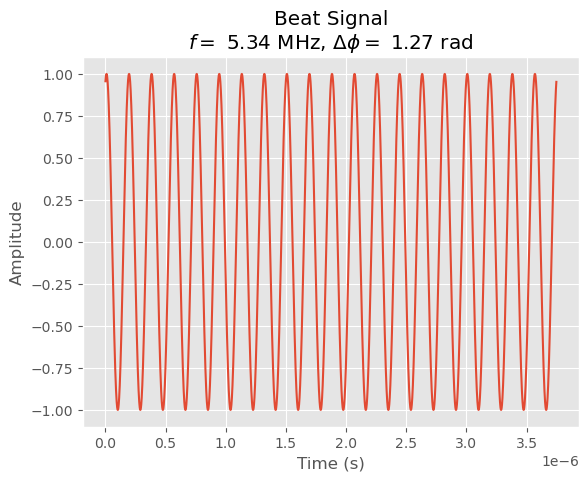

In [12]:
max_time = 20 / f_beat # s
N = 10000
Ts = max_time / N # s
fs = 1 / Ts # Hz

t = np.arange(0, max_time, 1 / fs)

beat_signal = np.sin(2 * pi * compute_f_beat(R) * t + phase_diff)

plt.plot(t, beat_signal)
plt.title(
    f"Beat Signal\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\Delta \\phi =\\ ${phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

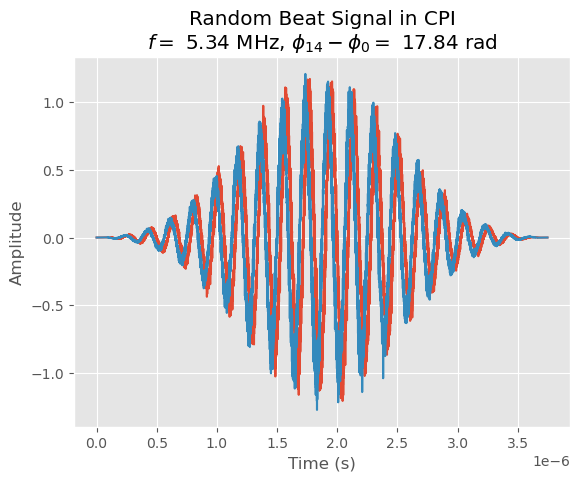

In [13]:
window = signal.windows.blackman(N)
cpi_single = np.array(
    [
        (
            np.sin(2 * pi * compute_f_beat(R) * t + m * phase_diff)
            + np.random.normal(0, 0.1, N)
        )
        * window
        for m in range(M)
    ]
)

n = randint(0, M - 1)

plt.plot(t, cpi_single[n])
plt.plot(t, cpi_single[0])
plt.title(
    f"Random Beat Signal in CPI\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

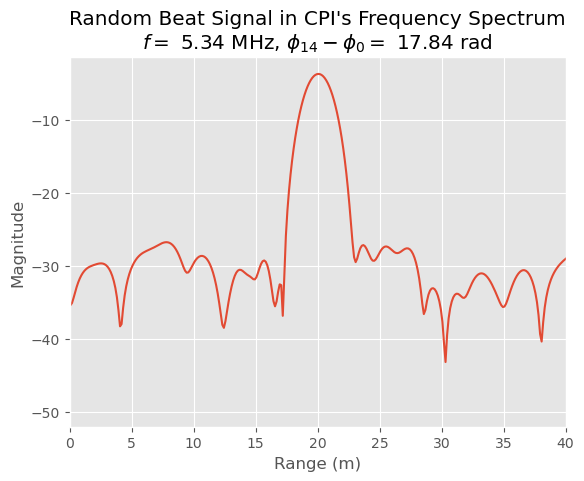

In [14]:
fft_len = N * 8
freq = np.linspace(-fs / 2, fs / 2, fft_len)

rmax = c * Tc * fs / (2 * bw)
n_ranges = np.linspace(-rmax / 2, rmax / 2, N)
ranges = np.linspace(-rmax / 2, rmax / 2, fft_len)

X_k = fftshift(fft(cpi_single[n], fft_len))
X_k /= N / 2
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.set_title(
    f"Random Beat Signal in CPI's Frequency Spectrum\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)

# Uncomment to plot over frequency axis instead
# ax.plot(freq / 1e6, X_k)
# ax.set_xlabel("Frequency (MHz)")
ax.plot(ranges, X_k)
ax.set_xlabel("Range (m)")

ax.set_ylabel("Magnitude")
ax.set_xlim([0, 40])
plt.show()

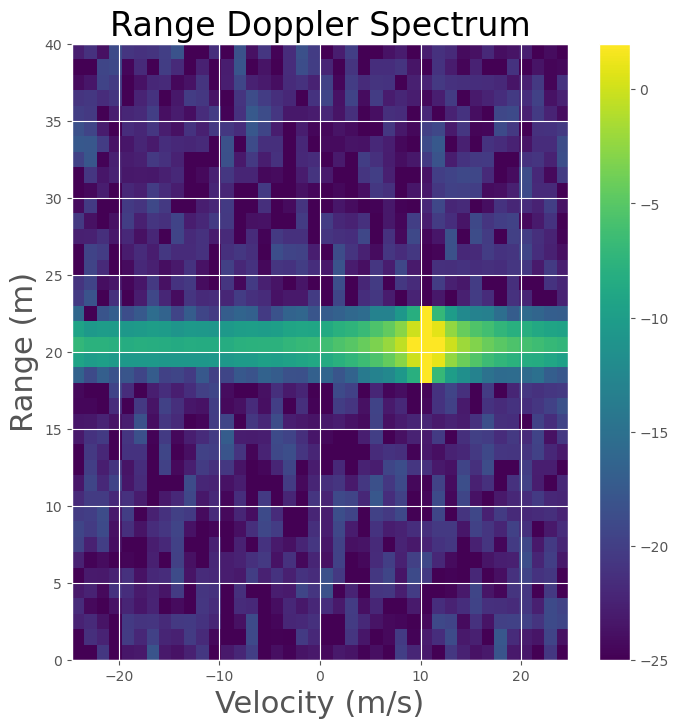

In [15]:
vels = np.linspace(-max_vel, max_vel, M)

range_doppler = fftshift(np.abs(fft2(cpi_single.T))) / (N / 2)

extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

fig, ax = plt.subplots(figsize=(8, 8))
range_doppler_plot = ax.imshow(
    10 * np.log10(range_doppler),
    aspect="auto",
    extent=extent,
    origin="lower",
    vmax=2,
    vmin=-25,
)
ax.set_ylim([0, 40])
ax.set_title("Range Doppler Spectrum", fontsize=24)
ax.set_xlabel("Velocity (m/s)", fontsize=22)
ax.set_ylabel("Range (m)", fontsize=22)
# ax.set_ylabel("Frequency (MHz)", fontsize=22)
fig.colorbar(range_doppler_plot)
plt.show()

## Multiple Targets
With multiple targets, the signal equation becomes

\begin{equation}
    \sum_{m=1}^{M} \sum_{n=1}^{N} \sin{\left( 2 \pi f_{beat,n} t + m\Delta \phi_n \right)}
\end{equation}

where $N$ is the number of targets in the scan volume, and $M$ is the number of chirps in the CPI.

In [16]:
def db_to_lin(x):
    return 10 ** (x / 10)

In [17]:
# Add, remove, or edit these targets and see what it does
targets = [
    (20, 10, 0),  # Target 1 @ 20 m with a velocity of 10 m/s and 0 dB relative power
    (20, -8, -5),  # Target 2 @ 20 m with a velocity of -8 m/s and -5 dB relative power
    (10, 5, -10),  # Target 3 @ 10 m with a velocity of 5 m/s and -10 dB relative power
]

sep = "\n\t"
print(
    f"Targets:",
    sep
    + sep.join(
        [
            f"{idx}: distance = {r:.2f} m, velocity = {v:.2f} m/s, relative power = {p:.1f} dB"
            for idx, (r, v, p) in enumerate(targets, start=1)
        ]
    ),
)

Targets: 
	1: distance = 20.00 m, velocity = 10.00 m/s, relative power = 0.0 dB
	2: distance = 20.00 m, velocity = -8.00 m/s, relative power = -5.0 dB
	3: distance = 10.00 m, velocity = 5.00 m/s, relative power = -10.0 dB


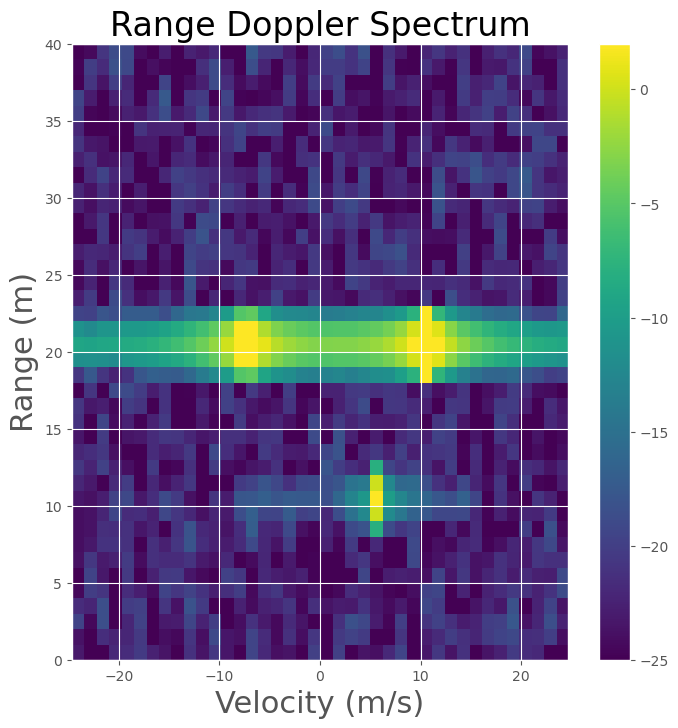

In [18]:
cpi = np.array(
    [
        (
            np.sum(
                [
                    np.sin(2 * pi * compute_f_beat(r) * t + m * compute_phase_diff(v))
                    * db_to_lin(p)
                    for r, v, p in targets
                ],
                axis=0,
            )
            + np.random.normal(0, 0.1, N)
        )
        * window
        for m in range(M)
    ]
)

range_doppler = fftshift(np.abs(fft2(cpi.T))) / (N / 2)

extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

fig, ax = plt.subplots(figsize=(8, 8))
range_doppler_plot = ax.imshow(
    10 * np.log10(range_doppler),
    aspect="auto",
    extent=extent,
    origin="lower",
    vmax=2,
    vmin=-25,
)
ax.set_ylim([0, 40])
ax.set_title("Range Doppler Spectrum", fontsize=24)
ax.set_xlabel("Velocity (m/s)", fontsize=22)
ax.set_ylabel("Range (m)", fontsize=22)
# ax.set_ylabel("Frequency (MHz)", fontsize=22)
fig.colorbar(range_doppler_plot)
plt.show()

## Example showing how the 2 targets at $R=20$ m are indistinguishable using only the Range-FFT spectrum

Note the decreased / increased magnitude of the target at $R = 20$ m due to the phase causing destructive or constructive interference.
Will depend on what random $n$ is plotted.

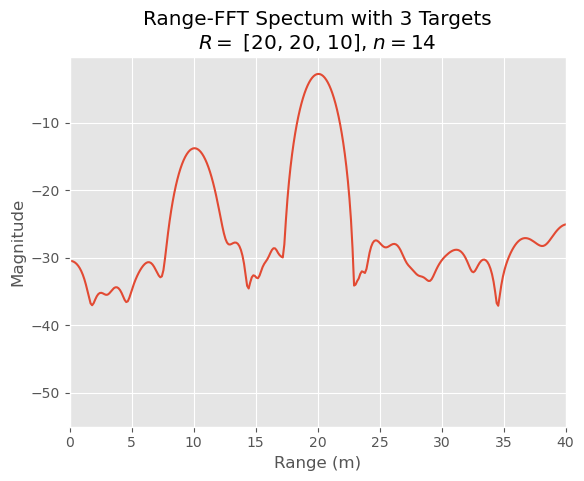

In [19]:
cpi_range_ffts = fft(cpi, n=fft_len, axis=1)
X_k = fftshift(cpi_range_ffts[n])
X_k /= N / 2
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.set_title(
    f"Range-FFT Spectum with 3 Targets\n"
    f"$R =\\ $[{', '.join([str(r) for r, v,p in targets])}], $n = {n}$"
)

ax.plot(ranges, X_k)
ax.set_xlabel("Range (m)")
ax.set_ylabel("Magnitude")
ax.set_xlim([0, 40])
plt.show()

## Takeaways

Normally we wouldn't be able to differentiate between the two targets at 20m, but since they have different velocities, they are separable!


## Example of detecting a moving target using only range

In [20]:
# speed_mph = 25  # mph
# speed = speed_mph * mph
speed = 10  # m/s
speed_mph = speed / mph
range_delta = speed * Tc
f_beat_delta = compute_f_beat(range_delta)
print(
    f"A target traveling at {speed_mph:.2f} mph ({speed:.2f} m/s) measured with a\n"
    f"radar operating with a sweep time of {Tc*1e6:.2f} us\n"
    f"would incur a pulse-to-pulse range delta of only\n"
    f"{range_delta:.4f} m and beat frequency delta of {f_beat_delta:.2f} Hz."
)
print(
    f"\nThis range delta is much smaller than the system's range resolution ({range_resolution/range_delta:.2f}x): {range_delta:.4f} m << {range_resolution:.4f} m"
)

A target traveling at 22.37 mph (10.00 m/s) measured with a
radar operating with a sweep time of 40.00 us
would incur a pulse-to-pulse range delta of only
0.0004 m and beat frequency delta of 106.74 Hz.

This range delta is much smaller than the system's range resolution (234.21x): 0.0004 m << 0.0937 m


## Surface Plotting

In [21]:
plot_vel = (-20, 20)  # m/s
plot_range = (0, 40)  # m

v_ind = np.where((vels > plot_vel[0]) & (vels < plot_vel[1]))[0]
vx = vels[v_ind[0] : v_ind[-1]]

r_ind = np.where((n_ranges > plot_range[0]) & (n_ranges < plot_range[1]))[0]
ry = n_ranges[r_ind[0] : r_ind[-1]]

rdz = range_doppler[r_ind[0] : r_ind[-1], v_ind[0] : v_ind[-1]]

X, Y = np.meshgrid(vx, ry, indexing="xy")

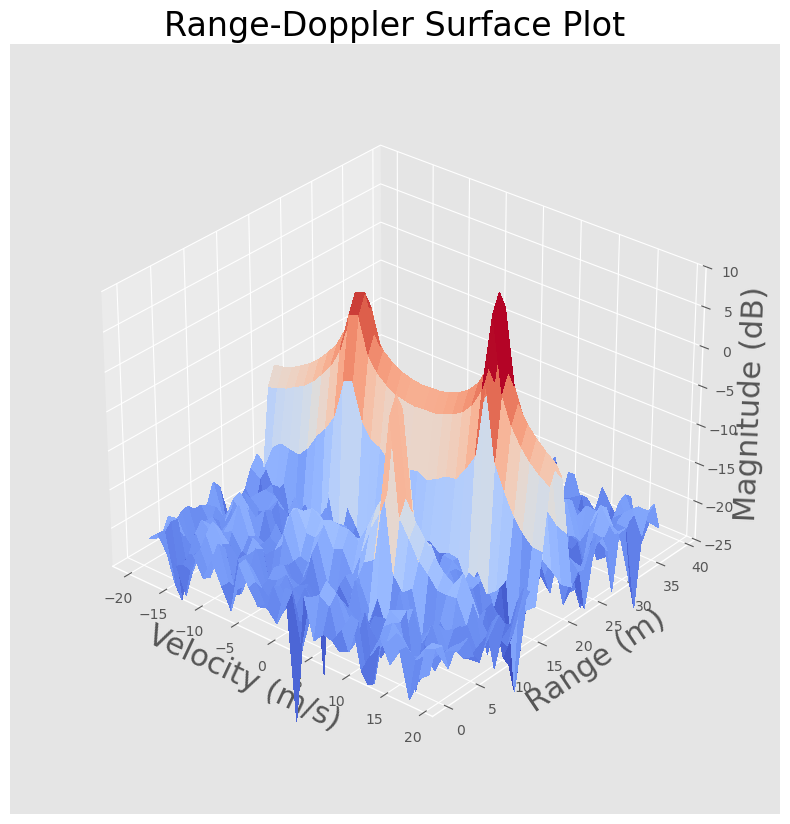

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, 10 * np.log10(rdz), cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(-25, 10)
ax.set_title("Range-Doppler Surface Plot", fontsize=24)
ax.set_xlabel("Velocity (m/s)", fontsize=22)
ax.set_ylabel("Range (m)", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-50, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

## Challenge Problem

To get the range-Doppler spectrum, we take the 2-dimensional Fourier Transform.
This gives us a spectrum of powers received at certain ranges and velocities.
In this notebook, there are cells computing the range-FFT spectrum, or the powers received by targets at different ranges, but we skipped from that straight to the 2D range-Doppler spectrum.

What if you wanted the spectrum of velocities at a single range? Say $R = 20$ m where there are two targets at differing velocities.

There are multiple ways to compute this, but you should get a plot showing the different targets and their velocities.

Once you compute it, try changing the `targets` variable and test if your output makes sense. Try changing the velocities, adding more targets, changing their relative powers, etc.

If you come up with an answer, post an image on [LinkedIn and tag me](https://tinyurl.com/linked-in-nb) or post a comment on the [YouTube video](https://tinyurl.com/doppler-video-nb)!

### Velocity Spectrum Example

Below is an example output if you want a reference, but yours could differ depending on your method.

Note how my example is shown with $M = 40$ which gives a pretty rough plot. You could increase this to get something cleaner, like our range-FFT spectrum. You could also play with windowing.

[Click here to go to the velocity spectrum example](https://drive.google.com/uc?id=16u8hSTEiVSYVzseBoSNo3FTi5ME4B8s7)